In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pylab
import seaborn as sns
#plt.style.use('seaborn')
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 10)

In [71]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive  # если вы выполняете код из среды Google Colab, нужно подключить свой гугл-диск,
drive.mount('/content/drive')   # чтобы можно было оттуда считать файл с данными для этого задания

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Кластеризация или обучение без учителя

Основное отличие методов обучения без учителя от классификации в том, что разметка для данных отсутствует. Задачи кластеризации возникают при снижении размерности задач, при обработке больших потоков данных (точность обработки при этом теряется, но скорость возрастает), при разработке отдельных моделей для каждого кластера и т.д.

Снижение размерности задач имеет ряд полезных свойств:
1. Увеличение скорости построения и работы классификатора;
2. Снижение зашумленности данных;
3. Снижение корреляции признаков;
4. Возможность визуализировать многомерные данные на плоскости и др.

Вначале познакомимся с методами кластеризации k-Means и агломеративным методом. Затем познакомимся с методами снижения размерности задач PCA и t-SNE. и на последок познакомимся с еще одним методом кластеризации DBSCAN. По каждому рассмотренному методу потребуется решить задание.

---

Общий принцип кластеризации: требуется разбить множество объектов на группы таким образом, чтобы элементы внутри одной группы (кластера) были похожи друг на друга, а элементы из разных групп отличались.

---

# Задание 1

1. Загрузите данные из файла ***данные для кластеризации.xlsx*** (находится в папке datasets).
2. Метки класса из столбца *Office* присвойте вектору *y*, остальные данные для кластеризации присвойте матрице *X*.
3. Нормализуйте данные матрицы X.
4. Импортируйте метод ***KMeans***.
5. Проведите анализ на количество кластеров с помощью метода локтя, а так же на основе метрик *silhouette_score*, *calinski_harabasz_score* и *davies_bouldin_score*. 
6. Сделайте выводы по результатам анализа.
7. Обучите модель *KMeans* с разбиением на два кластера.
8. Оцените результат с помощью *classification_report()*, сравнив попадание объектов в кластеры с реальными классами объектов из исходного файла с данными. Имейте в виду, что кластеры - это не классы, поэтому важно то, что одни и те же объекты попали внутрь одной группы, а не то, какой номер группы им присвоен моделью. На протяжении всех заданий мы будем оценивать качество кластеризации, сравнивая кластеры с классификацией данных по признакам: Rain и Office.
9. Оцените результат кластеризации с помощью функции *metrics4()* и заполните соответствующий столбец таблицы итогов кластеризации *m4*.
10. Сделайте выводы по результатам оценки качества кластеризации.

---

***Рекомендации:***

1. При проведении анализа на количество кластеров выбирайте верхнюю границу диапазона не меньше 100 (для метода локтя 50).
2. Не забывайте, что модель может нумеровать кластеры не в том порядке, как в данных.

In [ ]:
# повторим некоторые функции, которые пригодятся вам при решении задания

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Функция, которая строит график ошибок классификации TP, FP, TN, FN. Она нам понадобится
    для оценки качества кластеризации при сравнении кластеров с классами"""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
        thresh = 0.5   
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Class label')
    plt.xlabel('Cluster label')
    
def plot_dendrogram(model, **kwargs):
    """Функция, которая принимает модель агломеративной кластеризации и строит
    дендрограмму исследуемых данных"""
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    hierarchy.dendrogram(linkage_matrix, **kwargs)

def metrics4(X, labels, y):
    """Функция, которая вычисляет различные метрики, которые мы будем использовать
    для оценки качества кластеризации. Здесь у - это колонка с реальными метками
    классов датасета"""
    result = [adjusted_rand_score(y, labels)]
    result.append(silhouette_score(X, labels, random_state=21))
    result.append(calinski_harabasz_score(X, labels))
    result.append(davies_bouldin_score(X, labels))
    return result

m4 = pd.DataFrame(index = ['adjusted_rand_score', 'silhouette_score', 'calinski_harabasz_score', 
                           'davies_bouldin_score'])

## k-Means

[Алгоритм к-средних](https://ru.wikipedia.org/wiki/Метод_k-средних) один из самых популярных и простых методов кластеризации. 

Загрузим данные из файла данные для кластеризации.xlsx (находится в папке datasets).

In [5]:
df = pd.read_excel('/content/drive/MyDrive/school21/day04/datasets/данные_для_кластеризации.xlsx')

Присвоим метки класса из столбца Office вектору y, остальные данные для кластеризации матрице X.

In [97]:
y = df['Office']
X = df.drop('Office', axis=1)

y2 = df.Rain
X2 = df.drop('Rain', axis=1)

---

Нормализуем полученные данные:

In [98]:
# X = (X - X.mean(axis=0))/X.std(axis=0) 
# X2 = (X2 - X2.mean(axis=0))/X2.std(axis=0) 
X = preprocessing.StandardScaler().fit_transform(X.values)
X2 = preprocessing.StandardScaler().fit_transform(X2.values)


Импортируем метод [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
Метод к-средних требует указать количество формируемых кластеров. 
С целью визуализации данных, запишем их в DataFrame и построим графики:

In [9]:
from sklearn.cluster import KMeans

---

Для определения количества кластеров в данных можно воспользоваться "методом локтя". Суть метода заключается в том, что строится множество моделей к-средних с возрастающим количеством кластеров. По каждой модели считается метрика $J(C_k)$, которая представляет собой корень из суммы квадратов расстояний от точек до центройдов кластеров, к которым они относятся (***kmeans.inertia_***). Выбирается то количество кластеров, при котором метрика резко уменьшает свое снижение (локоть):

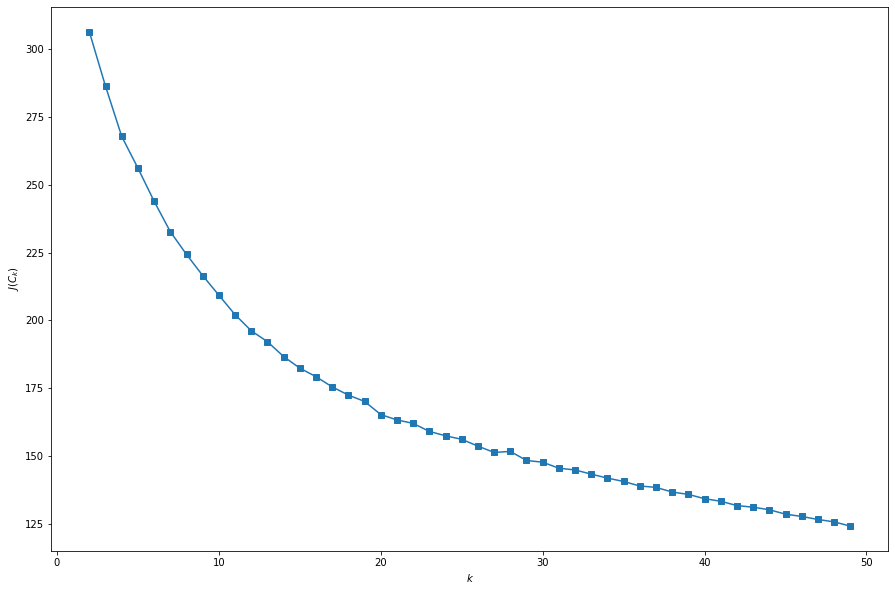

In [30]:
inertia = []
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, random_state=21).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(2, 50), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.show()

Из графика следует, что по методу локтя метрика резко уменьшает свое снижение при значении 2. adjusted_rand_score, silhouette_score, calinski_harabasz_score и davies_bouldin_score просчитаны ниже.

Далее просчитываем adjusted_rand_score, silhouette_score, calinski_harabasz_score и davies_bouldin_score  для количества кластеров от 2 до 100.

---

Как оценить качество кластеризации? Если разбиение на кластеры интуитивно понятно или имеются размеченные данные, то можно воспользоваться известными нам Precision, Recall и F-мерой, а в случае сбалансированности кластеров (в каждом кластере примерно одинаковое количество объектов), то можно воспользоваться Accuracy или его аналогом, [индексом Рэнда](https://en.wikipedia.org/wiki/Rand_index) - в библиотеке sklearn [adjusted_rand_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

In [42]:

from sklearn.metrics import adjusted_rand_score
# adjusted_rand_score(y, kmeans.labels_)


При индексе Рэнда равному 1 значит, что разбиение на кластеры полностью соответствует классам в данных.

silhouette_score позволяет оценить кластеризацию с точки зрения близости объектов к центройду кластера, к которому принадлежат, и удаленность от кластеров, к которым не принадлежат. Недостатком метрики является то, что она хорошо работает только с кластерами круглой формы.

In [44]:
from sklearn.metrics import silhouette_score

# silhouette_score(X, kmeans.labels_, random_state=21)

---

Близость silhouette_score к 1 говорит об идеальном разбиении на кластеры, к -1 - к идеально плохому разбиению.

Метрику silhouette_score можно применять для определения количества кластеров вместо метода локтя:

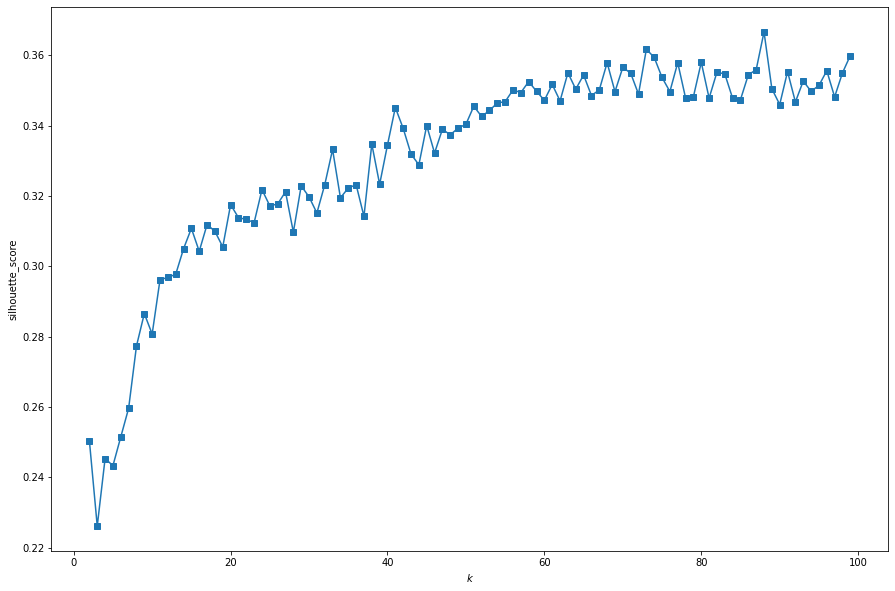

In [36]:
silhouette = []
for k in range(2, 100):
    km = KMeans(n_clusters=k, random_state=21).fit(X)
    silhouette.append(silhouette_score(X, km.labels_, random_state=21))

plt.plot(range(2, 100), silhouette, marker='s')
plt.xlabel('$k$')
plt.ylabel('silhouette_score')
plt.show()

Из графика метрики silhouette_score можно сделать вывод, что необходимо построить 88 кластеров. Ниже просчитаны adjusted_rand_score, silhouette_score, calinski_harabasz_score и davies_bouldin_score.

---

Максимальное значение silhouette_score на графике показывает, какое количество кластеров необходимо строить.

---

Метрика [Калински-Харабаса](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html) рассматривает отношение дисперсии объектов внутри кластера и дисперсии между кластерами. Недостатком метрики является отсутствие граничного значения, поэтому необходимо посчитать метрику в соседних разбиениях по кластерам в $k-1$ и $k+1$. Достоинство метрики - быстрое вычисление:

2705.6764709025756


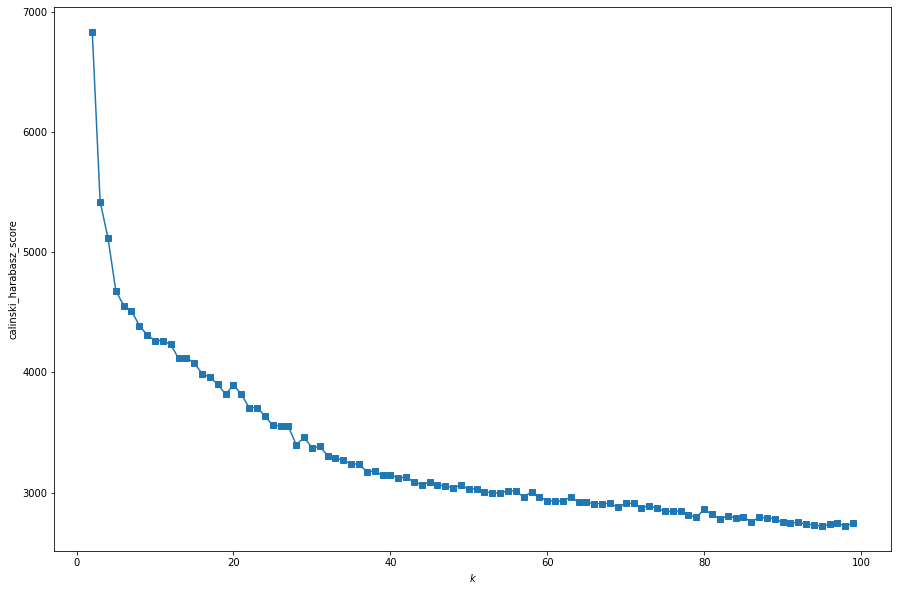

In [37]:
from sklearn.metrics import calinski_harabasz_score

kmeans100 = KMeans(n_clusters=100, random_state=21).fit(X)
print(calinski_harabasz_score(X, kmeans100.labels_))

ch = []
for k in range(2, 100):
    km = KMeans(n_clusters=k, random_state=21).fit(X)
    ch.append(calinski_harabasz_score(X, km.labels_))

plt.plot(range(2, 100), ch, marker='s')
plt.xlabel('$k$')
plt.ylabel('calinski_harabasz_score')
plt.show()

---

За счет скорости, метрика calinski_harabasz_score может быть лучшим способом определить количество кластеров.

---

Метрика [davies_bouldin_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html) так же оценивает близость объектов внутри кластера и удаленность от других кластеров. Чем ближе значение метрики к нулю - тем лучше.

1.0335087989028993


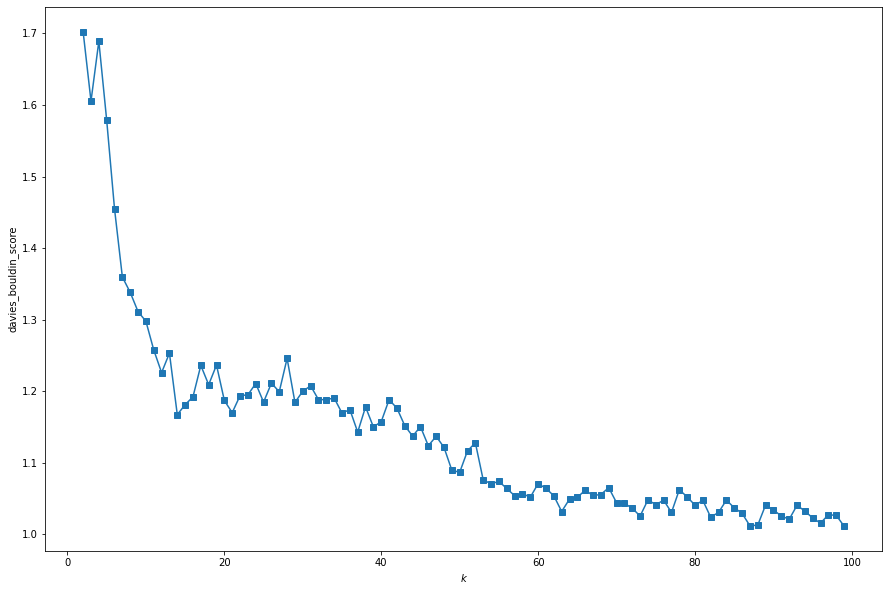

In [38]:
from sklearn.metrics import davies_bouldin_score

print(davies_bouldin_score(X, kmeans100.labels_))

db = []
for k in range(2, 100):
    km = KMeans(n_clusters=k, random_state=21).fit(X)
    db.append(davies_bouldin_score(X, km.labels_))

plt.plot(range(2, 100), db, marker='s')
plt.xlabel('$k$')
plt.ylabel('davies_bouldin_score')
plt.show()

Исходя из графика silhouette_score обучим модель KMeans с разбиением на 88 кластера и посчитаем значения метрик.

In [39]:
from sklearn.cluster import KMeans

kmeans88 = KMeans(n_clusters=88, random_state=21).fit(X)

In [45]:
def metrics4(X, labels, y):
    result = [adjusted_rand_score(y, labels)]
    result.append(silhouette_score(X, labels, random_state=21))
    result.append(calinski_harabasz_score(X, labels))
    result.append(davies_bouldin_score(X, labels))
    return result

m4 = pd.DataFrame(index = ['adjusted_rand_score', 'silhouette_score', 'calinski_harabasz_score', 
                           'davies_bouldin_score'])
m4['KMeans'] = metrics4(X, kmeans88.labels_, y)
m4

,KMeans
adjusted_rand_score,0.024657
silhouette_score,0.366704
calinski_harabasz_score,2792.571198
davies_bouldin_score,1.012664


# Выводы по результатам анализа
При делении кластеров на 88 наилучший показатель качества исключительно для метрики davies_bouldin_score (1,0127 против 1,7022 при делении на 2 кластера).


#Обучим модель KMeans с разбиением на два кластера.

In [99]:
from sklearn.cluster import KMeans

kmeans2 = KMeans(n_clusters=2, random_state=21).fit(X)
kmeans2rain = KMeans(n_clusters=2, random_state=21).fit(X2)

Оценим результат с помощью classification_report(), сравнив попадание объектов в кластеры с реальными классами объектов из исходного файла с данными. Кластеры - это не классы, поэтому важно то, что одни и те же объекты попали внутрь одной группы, а не то, какой номер группы им присвоен моделью. На протяжении всех заданий оцениваем качество кластеризации, сравнивая кластеры с классификацией данных по признакам: Rain и Office.

In [100]:
print(classification_report(y, kmeans2.labels_))
print(classification_report(y, kmeans2rain.labels_))

              precision    recall  f1-score   support

           0       0.13      0.15      0.14      9389
           1       0.21      0.19      0.20     11402

    accuracy                           0.17     20791
   macro avg       0.17      0.17      0.17     20791
weighted avg       0.18      0.17      0.17     20791

              precision    recall  f1-score   support

           0       0.07      0.09      0.08      9389
           1       0.07      0.06      0.06     11402

    accuracy                           0.07     20791
   macro avg       0.07      0.07      0.07     20791
weighted avg       0.07      0.07      0.07     20791



Значения метрик качества низкие ввиду изменения номера кластера, присвоенного моделью.
Перевернем значения у и пересчитаем метрики.

In [48]:
model_2 = KMeans(n_clusters=2, random_state=21).fit(X)
y1 = pd.DataFrame()
y1['Office'] = [1 - Office for Office in y]
print(classification_report(y1, model_2.labels_))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     11402
           1       0.79      0.85      0.82      9389

    accuracy                           0.83     20791
   macro avg       0.83      0.83      0.83     20791
weighted avg       0.83      0.83      0.83     20791



In [101]:
model_2rain = KMeans(n_clusters=2, random_state=21).fit(X2)
y1 = pd.DataFrame()
y1['Rain'] = [1 - Rain for Rain in y]
print(classification_report(y1, model_2rain.labels_))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     11402
           1       0.93      0.91      0.92      9389

    accuracy                           0.93     20791
   macro avg       0.93      0.93      0.93     20791
weighted avg       0.93      0.93      0.93     20791



In [49]:
def metrics4(X, labels, y):
    """Функция, которая вычисляет различные метрики, которые мы будем использовать
    для оценки качества кластеризации. Здесь у - это колонка с реальными метками
    классов датасета"""
    result = [adjusted_rand_score(y, labels)]
    result.append(silhouette_score(X, labels, random_state=21))
    result.append(calinski_harabasz_score(X, labels))
    result.append(davies_bouldin_score(X, labels))
    return result

m4 = pd.DataFrame(index = ['adjusted_rand_score', 'silhouette_score', 'calinski_harabasz_score', 
                           'davies_bouldin_score'])
m4['KMeans'] = metrics4(X, model_2.labels_, y)
m4

,KMeans
adjusted_rand_score,0.432206
silhouette_score,0.250400
calinski_harabasz_score,6832.006453
davies_bouldin_score,1.702163


In [102]:
m4['KMeans'] = metrics4(X, model_2rain.labels_, y)
m4

,KMeans,AgglomerativeClustering,DBSCAN
adjusted_rand_score,0.735321,0.589320,0.000000
silhouette_score,0.225689,0.223899,0.139928
calinski_harabasz_score,5885.643540,5819.019760,1495.153962
davies_bouldin_score,1.819499,1.787194,2.522183


#Выводы по результатам оценки качества кластеризации на 2 кластера
По результам оценки кластеризации по методу KMeans наилучшие метрики при делении на 2 кластера. В целом метод кластеризации KMeans дает плохие результаты, о чем свидетельствует низкие значения метрик 'adjusted_rand_score', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'.

---

# Задание 2

1. Обучите общую модель агломеративной кластеризации.
2. Сделайте вывод о количестве кластеров в данных на основе дендрограммы.
3. Обучите модель агломеративной кластеризации для двух кластеров.
4. Оцените качество кластеризации и запишите результаты в таблицу.
5. Сделайте выводы о результатах кластеризации.

---

---

## Агломеративный метод

Агломеративный метод - один из методов иерархической кластеризации. Иерархическая кластеризация позволяет получить не просто разбиение на кластеры, а целую иерархию вложенных кластеров. Агломеративный метод изначально считает каждый объект отдельным классом, затем на каждом шаге он начинает объединять попарно ближайшие классы. Алгоритм прекращает работу, когда все объекты объединены в один класс.

Достоинства метода:
1. В результате имеем иерархию возможных разбиений на кластеры.
2. Удобная визуализация результатов в виде дендрограммы.

Недостатки метода:
1. Требует большие объемы памяти компьютера.
2. Медленно работает при больших объемах данных.

---

Импортируем агломеративный методод [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) и [hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) от куда нам понадобится функция [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) для визуализации дендрограммы.

In [34]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

---

Напишем функцию подготовки данных и визуализации дендрограммы и обучим модель кластеризации агломеротивным методом:

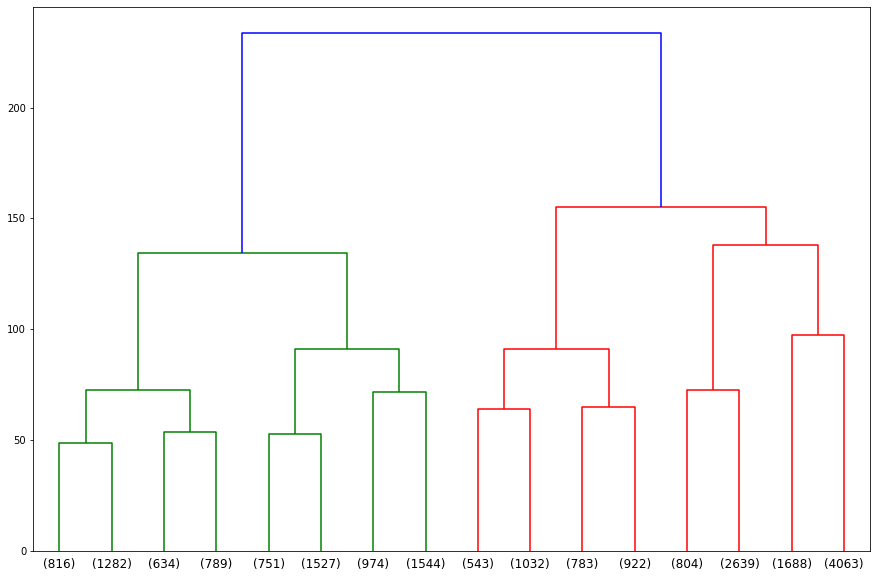

In [35]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    hierarchy.dendrogram(linkage_matrix, **kwargs)
    
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X)
plot_dendrogram(model, truncate_mode='level', p=3)

---

Количество кластеров в данных можно определить на основе дендрограммы - большие расстояния между кластерами и их объединением (ось ординат) свидетельствуют о различных кластерах. Анализируя полученную дендрограмму можно сделать вывод о наличии 2 кластеров.

Обучим модель непосредственно для 2 кластеров и оценим качество кластеризации:

In [52]:
model_2 = AgglomerativeClustering(n_clusters=2).fit(X)
print(classification_report(y, model_2.labels_))

              precision    recall  f1-score   support

           0       0.14      0.19      0.16      9389
           1       0.08      0.06      0.07     11402

    accuracy                           0.12     20791
   macro avg       0.11      0.12      0.11     20791
weighted avg       0.11      0.12      0.11     20791



In [57]:
##Значения метрик качества низкие ввиду изменения номера кластера, присвоенного моделью. Перевернем значения у и пересчитаем метрики.
# y1 = pd.DataFrame()
# y1['Office'] = [1 - Office for Office in y]
# print(classification_report(y1, model_2.labels_))

Посмотрим визуализацию кластеризации:

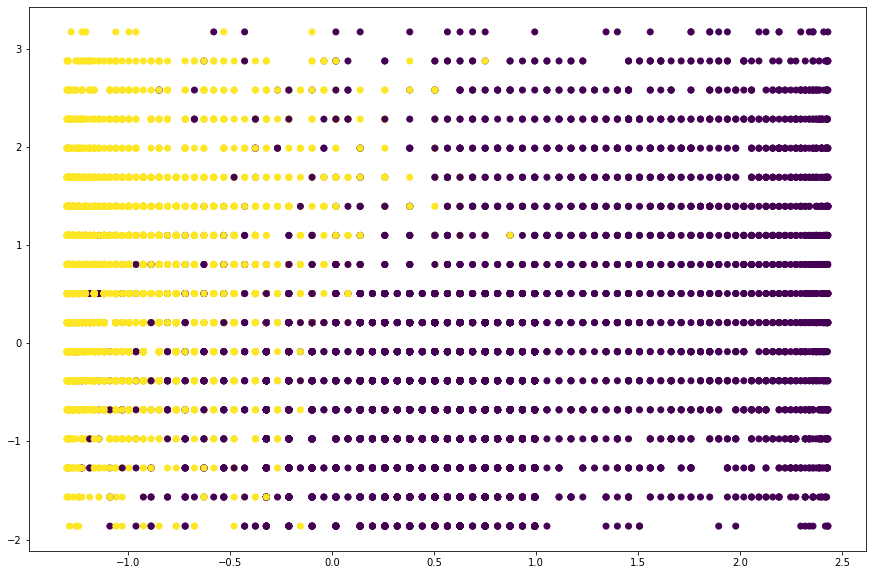

In [58]:
plt.scatter(X[:,2], X[:,4], c=model_2.labels_)
plt.show()

Визуальный анализ показывает, что все кластеры были верно предсказаны. Следовательно проблема в том, что метод просто нумерует кластеры не в той последовательности, что заложена изначально. Проверим это:

In [56]:
for j in range(model_2.labels_.max()+1):
    print('метка класса =', j, '   метка кластера =', model_2.labels_[y==j].mean(), 
          '   стандартное отклонение меток кластера =', model_2.labels_[y==j].std())

метка класса = 0    метка кластера = 0.8143572265416977    стандартное отклонение меток кластера = 0.3888181247331607
метка класса = 1    метка кластера = 0.05884932467988072    стандартное отклонение меток кластера = 0.2353424773911474


In [60]:
y_ac = np.full(y.shape, fill_value=np.nan)
for j in range(4):
     y_ac[y == j] = round(model_2.labels_[y==j].mean(), 0)
print(classification_report(y_ac, model_2.labels_))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     11402
         1.0       0.92      0.81      0.86      9389

    accuracy                           0.88     20791
   macro avg       0.89      0.88      0.88     20791
weighted avg       0.89      0.88      0.88     20791



Подсчитаем и запишем в таблицу метрики качества кластеризации:

In [62]:
m4['AgglomerativeClustering'] = metrics4(X, model_2.labels_, y_ac)
m4

,KMeans,AgglomerativeClustering
adjusted_rand_score,0.432206,0.589320
silhouette_score,0.250400,0.223899
calinski_harabasz_score,6832.006453,5819.019760
davies_bouldin_score,1.702163,1.787194


##Выводы
По результам оценки кластеризации по агломеративному методу наилучшие метрики качества при делении на 2 кластера. В целом низкие значения метрик 'adjusted_rand_score', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score' свидетельствуют о том, что метод данный кластеризации дает плохие результаты

---

# Задание 3

1. Обучить модель для 6 главных компонент.
2. Визуализировать сохраненную дисперсию.
3. Определить количество главных компонент, сохраняющих не менее 90% дисперсии.
4. Обучить модель для двух главных компонент и визуализировать данные.
5. Сделать выводы об эффективности применения метода главных компонент к решаемой задаче. По какому признаку можно разделить выборку на кластеры?

## Метод главных компонент

Метод главных компонент [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) позволяет с помощью линейных преобразований исходных признаков перейти в новое признаковое пространство. В результате преобразований появляется возможность снизить количество признаков при минимальной потере дисперсии. Количество главных компонент опеределяется исследователем на основании требования к сохраненной дисперсии. Обычно ориентируются на 90% дисперсии, но, исходя из конкретики задачи, требование к сохраненной дисперии может быть и больше и меньше. Например, при сильном шуме в данных, требование к сохраненной дисперсии может быть значительно ниже 90%. Порог сохраненной дисперсии может определяться эксперементально, на основе качества решения итоговой задачи.

Достоинства метода главных компонент:
1. Главные компоненты ортогональны друг другу, что позволяет решить проблему мультиколлинеарности признаков.
2. В случае большого количества исходных признаков, позволяет снизить вычислительную нагрузку в задачах классификации и регресии с незначительной потерей качества результата.
3. За счет отбрасывания части главных компонент, позволяет снизить шум в данных, что снижает эффект переобучения моделей.

Недостатки метода:
1. Плохо работает в случае низкой корреляции среди исходных признаков.
2. Плохо работает для визуализации многомерных пространств признаков на плоскости.

---

Импортируем метод PCA и обучим модель для 6 главных компонент:

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=6, random_state=21)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

---

Визуализируем накопленную сохраненную димперсию:

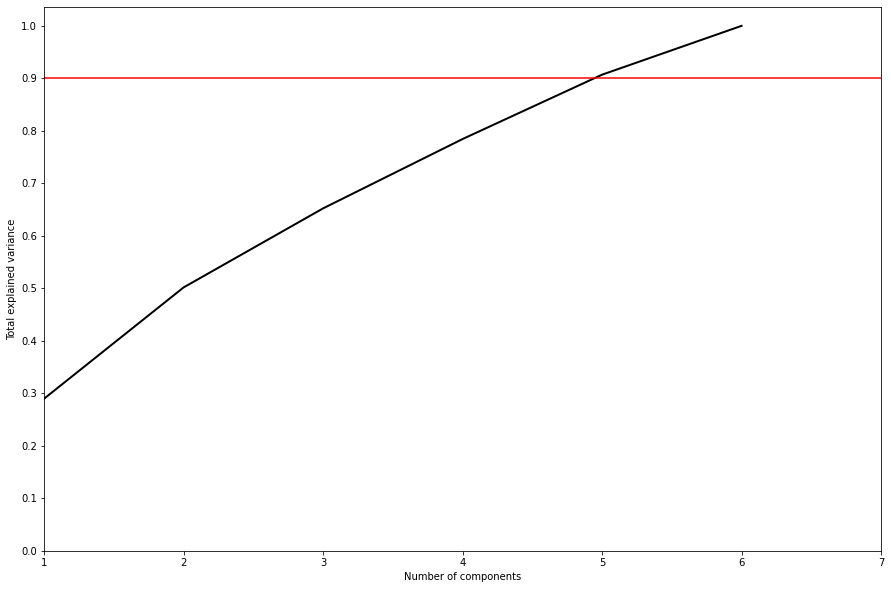

In [27]:
plt.plot(np.arange(1,7), np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(1, 7)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')
plt.show()

In [29]:
print('Первые четыре главных компоненты сохраняют', str(round(100*pca.explained_variance_ratio_[:4].sum(),2))+'%', 
      'дисперсии, пять компонент -', str(round(100*pca.explained_variance_ratio_[:5].sum(),2))+'%')

Первые четыре главных компоненты сохраняют 78.44% дисперсии, пять компонент - 90.7%


---

Обучим модель для двух главных компонент и визуализируем данные.

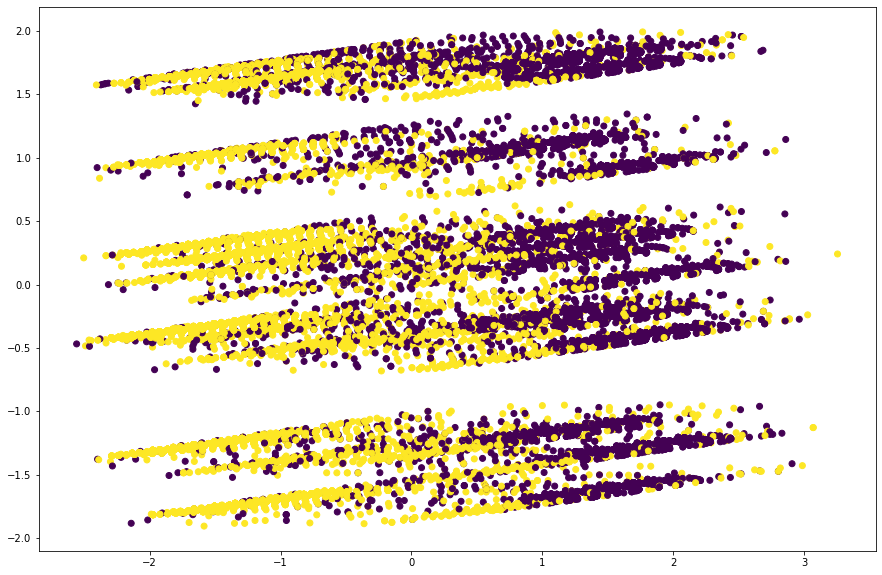

In [21]:
pca = PCA(n_components=2, random_state=21)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.show()

---
##Выводы
Два кластера оказались достаточно близко друг к другу. На графике видно, что кластеры пересекаются.
Данный метод неэффективен к применению к решаемой задаче

---

# Задание 4

Визуализируйте данные с помощью t-SNE при различных значениях perplexity. По какому признаку можно разделить данные на кластеры при достаточно большом значении perplexity?

---

## t-SNE

[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) - еще один метод снижения размерности. В отличие от метода главных компонент, t-SNE сжимает данные таким образом, чтобы сохранить их структуру. При этом полученное расстояние в сжатом признаковом в пространстве скорее всего никак не будет соотносится с расстояниями в исходном признаковом в пространстве. Метод пытается перенести окрестность каждой точки из исходного пространства в сжатое. 

Достоинства метода:
1. Метод прост в применении.
2. Работает с большими объемами данных.
3. Эффективен при визуализации на плоскости многомерных данных.

Недостатки метода:
1. Полученные результаты практически не интерпретируются.
2. Может найти структуру в абсолютном шуме.

---

Импортируем метод t-SNE:

In [93]:
from google.colab import drive # если вы выполняете код из среды Google Colab, нужно подключить свой гугл-диск,
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/MyDrive/school21/day04/datasets/данные_для_кластеризации.xlsx')

y = df['Office']
y1 = df['Rain']
X = df.drop('Office', axis=1)

X = (X - X.mean(axis=0))/X.std(axis=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Обучим модели при различных значениях perplexity и визуализируем результаты:

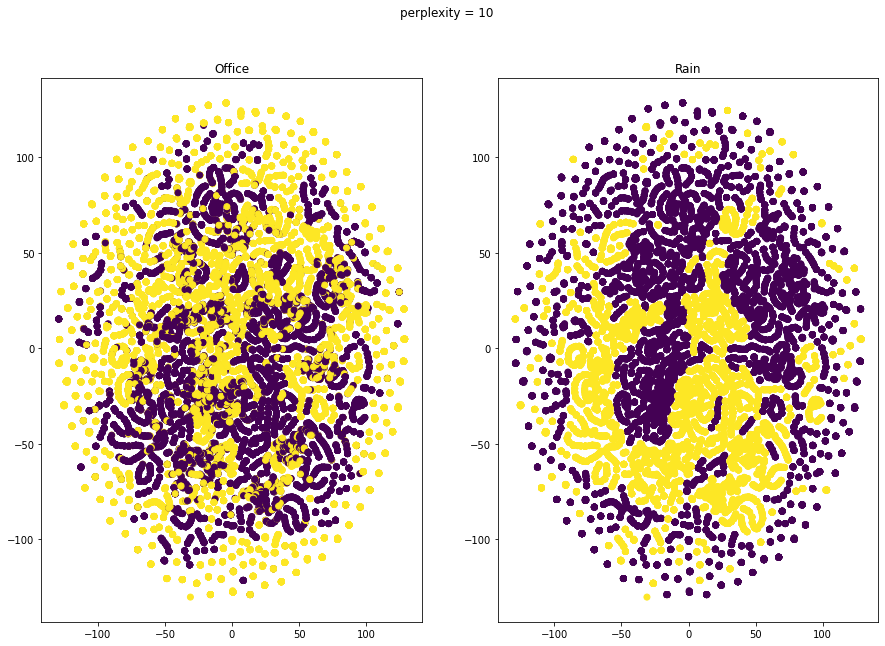

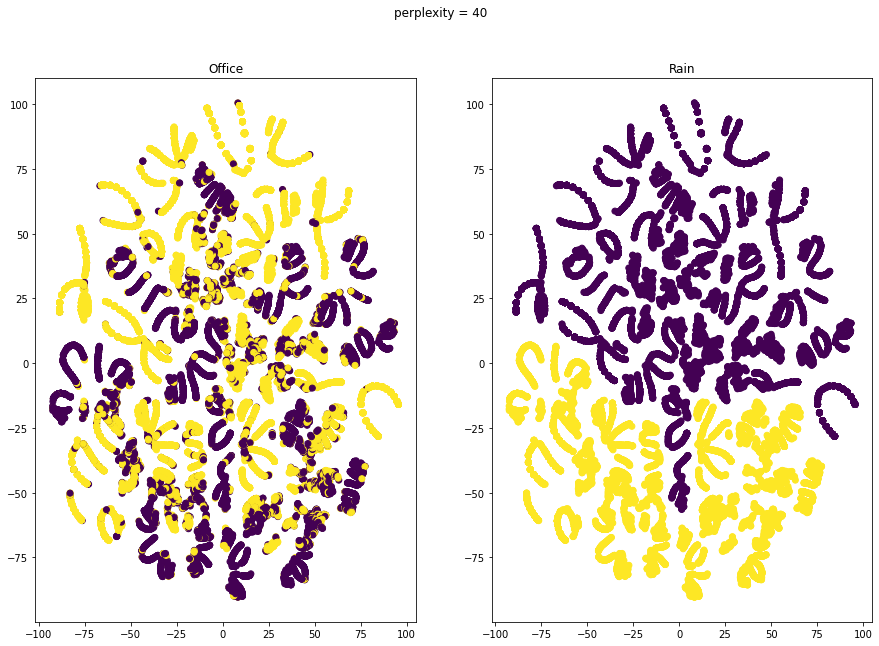

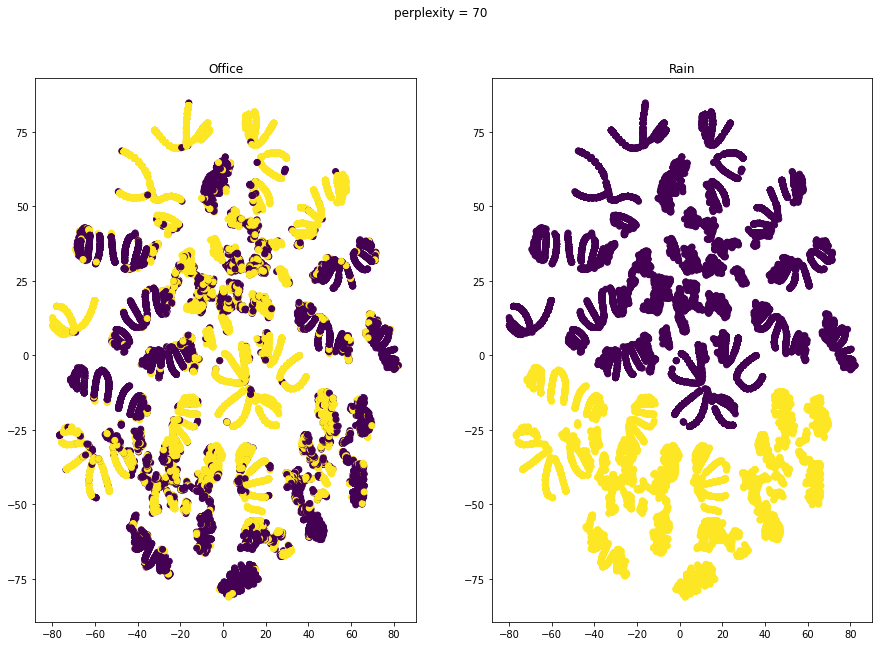

In [96]:
from sklearn.manifold import TSNE

max_perplexity = 70
max_components = 6

for p in range(10, max_perplexity + 1, 30):
  tsne = TSNE(n_components=2, perplexity=p, random_state=21)
  tsne_representation = tsne.fit_transform(X)
  fig, ax = plt.subplots(1, 2)
  fig.suptitle(f'perplexity = {p}')
  ax[0].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y)
  ax[0].set_title('Office')
  ax[1].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=y1)
  ax[1].set_title('Rain')
  plt.show()

Данный метод эффективно кластеризует при значении perplexity = 40 при определении кластеров Rain.

---

# Задание 5

1. Заголовок последнего графика содержит ошибку "19 кластера". Необходимо написать функцию ***add_a_ov(n, word)***, которая поможет исправить ошибку. Функция обладает следующими характеристиками:
    - Функция получает на вход два параметра n и word:
        - n - числительное в виде целого числа; 
        - word - существительное мужского рода в единственном числе в именительном падеже.
    - Функция возвращает измененное word в соответствии с числительным n.
    - Примеры выполнения функции:
        - *add_a_ov(1, 'кластер')* вернет 'кластер';
        - *add_a_ov(2, 'кластер')* вернет 'кластера';
        - *add_a_ov(5, 'кластер')* вернет 'кластеров'.
        
        
2. Внесите изменения в функцию ***viz_dbscan()*** с учетом реализации функции ***add_a_ov(n, word)***.
3. Обучите модель DBSCAN с параметрами по умолчанию и визуализируйте результат.
4. Проведите поиск гиперпараметра ***eps***.
5. Проведите визуализацию зависимости количества кластеров от параметра ***eps***.
6. Обучите модель DBSCAN с таким параметром ***eps***, чтобы получить разбиение на два кластера.
7. Визуализируйте результат.
8. Проведите анализ соответствия полученных кластеров классам.
9. Оцените качество кластеризации и запишите результаты в таблицу.
10. Сделайте общий вывод по результатам кластеризации различными методами.

---

## DBSCAN

Еще один метод кластеризации - [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

Достоинства метода:

1. Самостоятельно определяет количество кластеров в зависимости от параметра eps.
2. Кроме кластеров определяет шум.
3. Работает с кластерами разной формы.

Недостатки метода:

1. С помощью метода невозможно проверить гипотезу о количестве кластеров, т.к. метод определяет их самостоятельно.
2. Необходим поиск параметра eps.
3. Не работает, если кластеры разной плотности.

Импортируем метод:

In [67]:
from sklearn.cluster import DBSCAN

---

Для отображения результатов на плоскости снизим размерность задачи с помощью t-SNE

In [68]:
tsne = TSNE(n_components=2, perplexity=15, random_state=21)
tsne_X = tsne.fit_transform(X)

---

Обучим модель с параметрами по умолчанию и напишем функцию визуализации результатов кластеризации:

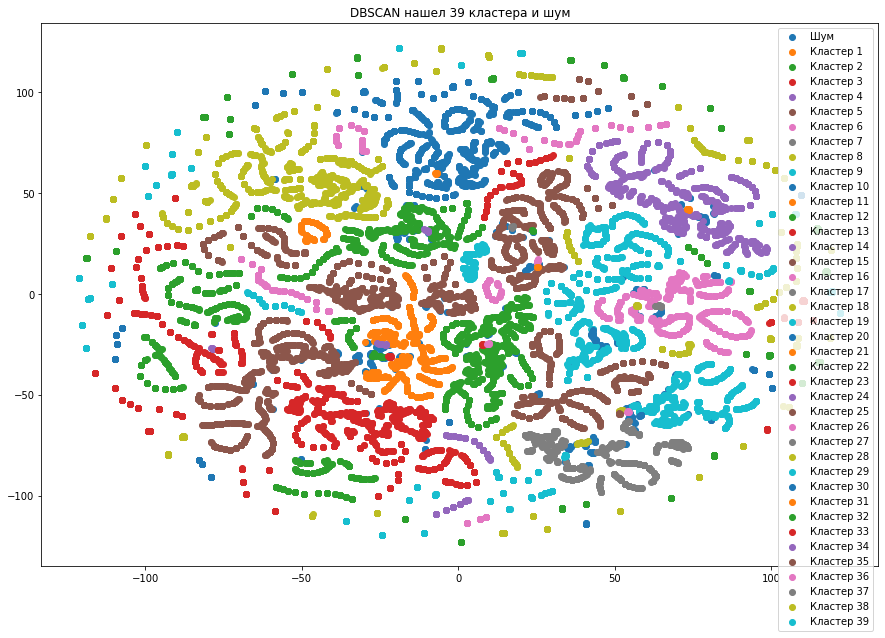

In [72]:
dbscan = DBSCAN(eps=0.5)
dbscan.fit(X)

def viz_dbscan(labels, x2d):
    clstr = []
    k = labels.min()
    if k == -1:
        title = ['DBSCAN нашел ', ' кластера и шум']
    else:
        title = ['DBSCAN нашел ', ' кластера']
    for j in range(k, labels.max()+1):
        plt.scatter(x2d[labels==j, 0], x2d[labels==j, 1])
        if j == -1:
            clstr = ['Шум']
        else:
            clstr.append('Кластер '+str(j+1))
    plt.legend(clstr)
    plt.title(title[0] + str(len(clstr)+k) + title[1])
    plt.show()
    
viz_dbscan(dbscan.labels_, tsne_X)

---

Кластеры определены верно, но найден шум, который в принципе необходимо удалить. Попробуем изменить параметр ***eps*** модели. В этом нам поможет [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html). Установим количество ближайших соседей *n_neighbors=25*, это означает что в кластере должно быть не менее 25 объектов.

In [73]:
from sklearn.neighbors import NearestNeighbors

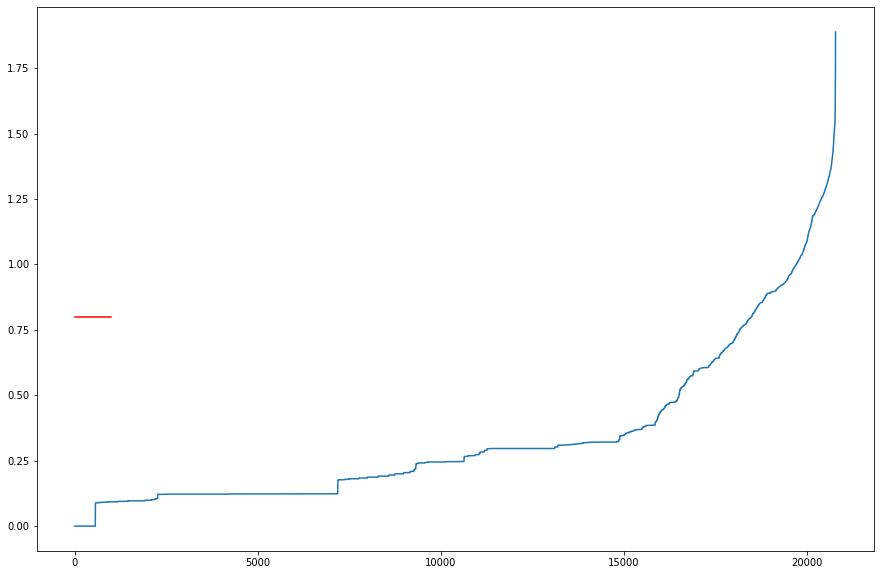

In [74]:
model_NN = NearestNeighbors(n_neighbors=25)
model_NN.fit(X)
dist, _ = model_NN.kneighbors(X, n_neighbors=25, return_distance=True)
dist = np.sort(dist[:,-1])
plt.plot(dist)
plt.plot([0,1000], [0.8, 0.8], 'r')
plt.show()

---

Параметр ***eps*** по оси ординат необходимо выбрать так, чтобы после пересечения прямой с графиком, график шел вертикально вверх. Построим модель с eps=0.8:

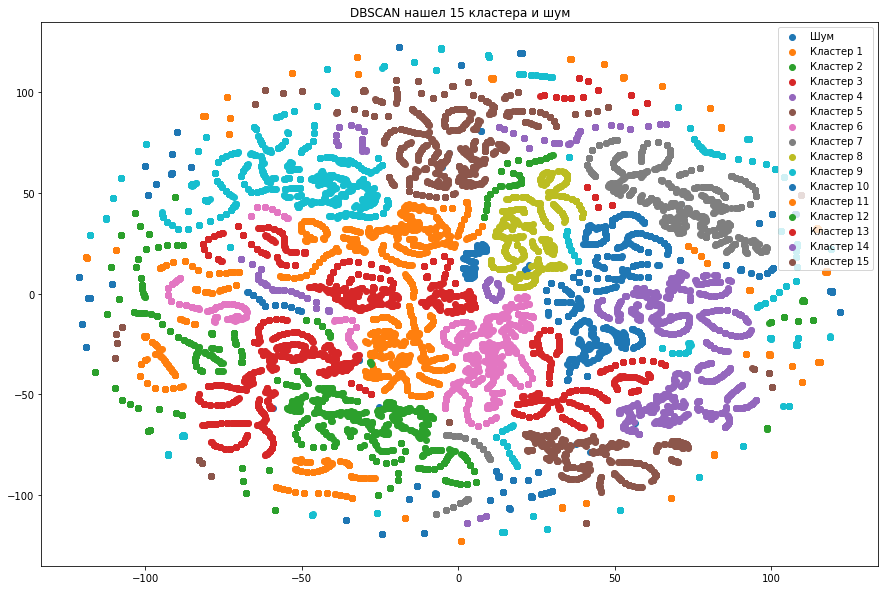

In [75]:
dbscan = DBSCAN(eps=0.8)
dbscan.fit(X)
viz_dbscan(dbscan.labels_, tsne_X)

---

DBSCAN верно определил кластеры и не нашел шума.

---

Оценим качество кластеризации:

In [76]:
for j in range(dbscan.labels_.max()+1):
    print('метка класса =', j, '   метка кластера =', dbscan.labels_[y==j].mean(), 
          '   стандартное отклонение меток кластера =', dbscan.labels_[y==j].std())

метка класса = 0    метка кластера = 7.640856321226968    стандартное отклонение меток кластера = 3.8257799932476764
метка класса = 1    метка кластера = 7.433608138922996    стандартное отклонение меток кластера = 3.504329161162538
метка класса = 2    метка кластера = nan    стандартное отклонение меток кластера = nan
метка класса = 3    метка кластера = nan    стандартное отклонение меток кластера = nan
метка класса = 4    метка кластера = nan    стандартное отклонение меток кластера = nan
метка класса = 5    метка кластера = nan    стандартное отклонение меток кластера = nan
метка класса = 6    метка кластера = nan    стандартное отклонение меток кластера = nan
метка класса = 7    метка кластера = nan    стандартное отклонение меток кластера = nan
метка класса = 8    метка кластера = nan    стандартное отклонение меток кластера = nan
метка класса = 9    метка кластера = nan    стандартное отклонение меток кластера = nan
метка класса = 10    метка кластера = nan    стандартное отклон

In [78]:
y_ac = np.full(y.shape, fill_value=np.nan)
for j in range(4):
     y_ac[y == j] = int(dbscan.labels_[y==j].mean())
print(classification_report(y_ac, dbscan.labels_))

ValueError: ignored

In [79]:
m4['DBSCAN'] = metrics4(X, dbscan.labels_, y_ac)
m4

,KMeans,AgglomerativeClustering,DBSCAN
adjusted_rand_score,0.432206,0.589320,0.000000
silhouette_score,0.250400,0.223899,0.139928
calinski_harabasz_score,6832.006453,5819.019760,1495.153962
davies_bouldin_score,1.702163,1.787194,2.522183


---

Все методы показали одинаковые значения метрик качества кластеризации, в силу того, что продемонстрировали одинаковые результаты.

---

Можно посмотреть, при каких значениях eps сколько кластеров строит DBSCAN. Например, следующий код строит зависимость количества кластеров от eps, изменяющегося от 0.1 до 0.99:

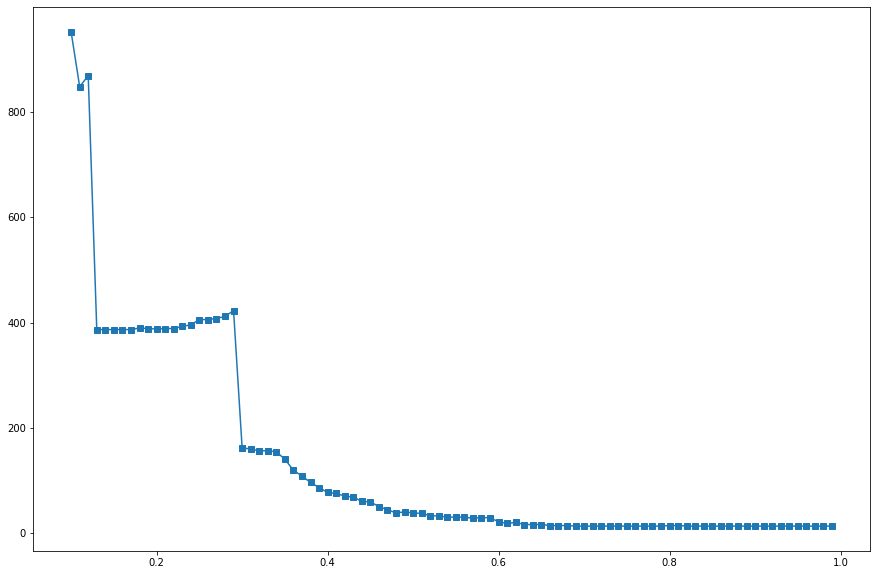

In [80]:
epsilon = []
n_claster = []
for j in range(10, 100, 1):
    dbscan = DBSCAN(eps=j/100)
    dbscan.fit(X)
    epsilon.append(j/100)
    n_claster.append(dbscan.labels_.max()+1)
plt.plot(epsilon, n_claster, marker='s')
plt.show()

---

И можно посмотреть, как DBSCAN разбивает наши данные на 19 кластеров (eps=0.18):

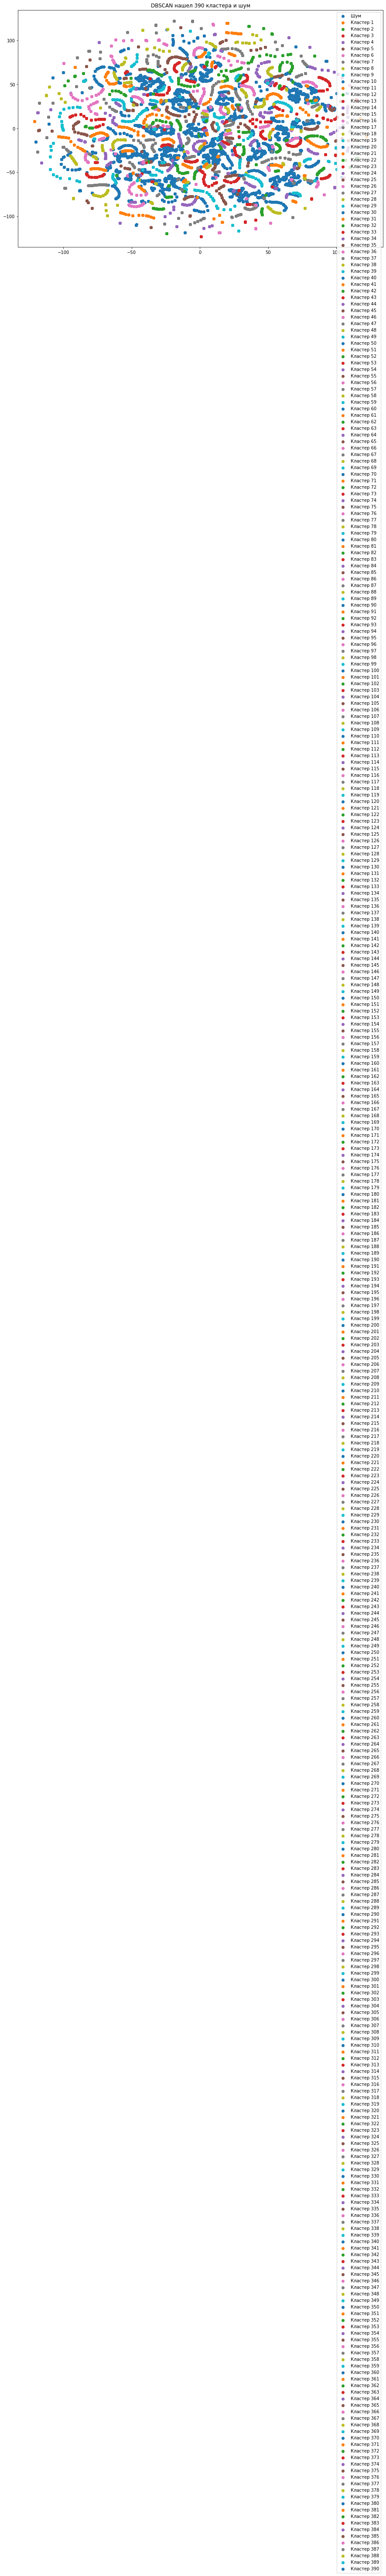

In [83]:
dbscan = DBSCAN(eps=0.18)
dbscan.fit(X)
viz_dbscan(dbscan.labels_, tsne_X)

---

Для оценки качества полученного разбиения не обязательно применять метрики, достаточно взглянуть на процент данных, определенных как шум:

In [ ]:
print('DBSCAN определил', str(len(dbscan.labels_[dbscan.labels_==-1])/10) +'%', 'данных как шум')

---

# Задание 5

1. Заголовок последнего графика содержит ошибку "19 кластера". Необходимо написать функцию ***add_a_ov(n, word)***, которая поможет исправить ошибку. Функция обладает следующими характеристиками:
    - Функция получает на вход два параметра n и word:
        - n - числительное в виде целого числа; 
        - word - существительное мужского рода в единственном числе в именительном падеже.
    - Функция возвращает измененное word в соответствии с числительным n.
    - Примеры выполнения функции:
        - *add_a_ov(1, 'кластер')* вернет 'кластер';
        - *add_a_ov(2, 'кластер')* вернет 'кластера';
        - *add_a_ov(5, 'кластер')* вернет 'кластеров'.
        
        
2. Внесите изменения в функцию ***viz_dbscan()*** с учетом реализации функции ***add_a_ov(n, word)***.
3. Обучите модель DBSCAN с параметрами по умолчанию и визуализируйте результат.
4. Проведите поиск гиперпараметра ***eps***.
5. Проведите визуализацию зависимости количества кластеров от параметра ***eps***.
6. Обучите модель DBSCAN с таким параметром ***eps***, чтобы получить разбиение на два кластера.
7. Визуализируйте результат.
8. Проведите анализ соответствия полученных кластеров классам.
9. Оцените качество кластеризации и запишите результаты в таблицу.
10. Сделайте общий вывод по результатам кластеризации различными методами.

In [84]:
def add_a_ov(n, word):
    n = n%100
    if n%10 in [2,3,4] and n//10 != 1:
        result = word + 'а'
    elif n%10 == 1 and n != 11:
        result = word
    else:
        result = word + 'ов'
    return result

In [87]:
def viz_dbscan(labels, x2d):
    clsr = []
    k = labels.min()
    if k == -1:
      title = ['DBSCAN нашел', 'и шум']
    else:
      title = ['DBSCAN нашел', '']
    for j in range(k, labels.max()+1):
      plt.scatter(x2d[labels==j, 0], x2d[labels==j, 1])
      if j == -1:
        clsr = ['шум']
      else:
        clsr.append('Кластер'+str(j+1))
    n = len(clsr)+k
    plt.legend(clsr)
    plt.title(f'{title[0]} {n} {add_a_ov(n, "кластер")} {title[1]}')
    plt.show()

In [88]:
# код проверки правильности функции add_a_ov. Запустите его, чтобы узнать, правильно ли описана функция

def test(n, word):
    n = n%100
    if n%10 in [2,3,4] and n//10 != 1:
        result = word + 'а'
    elif n%10 == 1 and n != 11:
        result = word
    else:
        result = word + 'ов'
    return result


for j in [i for i in range(31)]+[101,102,105,111,112,1001,1002,1005,1011,1012,1021,1022]:
    if test(j, 'слон') != add_a_ov(j, 'слон'):
        break
if j < 1022:
    print(j, add_a_ov(j, 'слон'))
    if j < 10:
        print('Функция содержит критичные ошибки')
    elif j < 20:
        print('Функция содержит критичные ошибки. Не верно обрабатываются числительные от 11 до 14')
    elif j < 100:
        print('Функция содержит критичные ошибки. Не верно обрабатываются числительные от 20 до 100')
    elif j < 1000:
        print('Функция содержит не критичные для задачи ошибки.', 
              'Не верно обрабатываются числительные свыше 100')
    elif j >= 1000:
        print('Функция содержит не критичные для задачи ошибки.', 
              'Не верно обрабатываются числительные от 1000 и выше')
else:
    print('Функция работает нормально')

Функция работает нормально
